# Emerging Technologies Project
## Cathal Butler | G00346889
### References
* https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..index#0
* https://www.tensorflow.org/guide/data_performance
* https://codelabs.developers.google.com/codelabs/keras-flowers-data/#3
* https://keras.io/examples/mnist_cnn/
* https://www.ics.uci.edu/~mohamadt/keras_mnist.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.
/home/cathal/OneDrive - GMIT/Year_4_Software_Development/Emerging_Technologies/emerging-technologies-project/Emerging-Technologies-Project/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cathal/OneDrive - GMIT/Year_4_Software_Development/Emerging_Technologies/emerging-technologies-project/Emerging-Technologies-Project/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cathal/OneDrive - GMIT/Year_4_Software_Development/Emerging_Technologies/emerging-technologies-project/Emerging-Tec

In [2]:
# The number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need.
batch_size = 128
num_classes = 10
# Setting the number of forward passes and backward passes of all the training examples
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28

# Load data. The data, split between train and test sets:
(x_train, y_train), (X_test, y_test) = mnist.load_data()
# Print the original X & Y train shape:
print("Original X shape", x_train.shape)
print("Original Y shape", y_train.shape)

# Reshape data.
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # Original data is uint8 (0-255). Scale it to range [0,1].
x_test  /= 255
print("Training X matrix shape", x_train.shape)
print("Testing X matrix shape", X_test.shape)
print (y_train[0])    
    
# Represent the targets as one-hot vectors: e.g. 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0].
nb_classes = 10
# Printing out the training and testing matrix shape
print("Training Y matrix shape", y_train.shape)
print("Testing Y matrix shape", y_test.shape)

Original X shape (60000, 28, 28)
Original Y shape (60000,)
Training X matrix shape (60000, 28, 28, 1)
Testing X matrix shape (10000, 28, 28)
5
Training Y matrix shape (60000,)
Testing Y matrix shape (10000,)


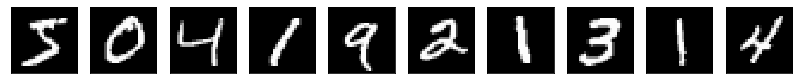

In [3]:
# Plot examples of the data.
plt.figure(1, figsize=(14,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

In [ ]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Keras Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)             

In [ ]:
# Keras Summary
model.summary()

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
# Training the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])